In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline

Training the model again to use the results later in this notebook

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
lead = pd.read_csv('Leads.csv')

lead['Total Time Spent on Website'] = pd.to_numeric(lead['Total Time Spent on Website'], errors='coerce')
lead['Total Time Spent on Website'] = lead['Total Time Spent on Website'].fillna(0)

lead.columns = lead.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(lead.dtypes[lead.dtypes == 'object'].index)


for c in categorical_columns:
    lead[c] = lead[c].str.lower().str.replace(' ', '_')
    lead[c] = lead[c].replace(to_replace=np.nan, value="unk")

lead.converted = (lead.converted == 1).astype(int)

In [4]:
print(lead['converted'].value_counts())


converted
0    5679
1    3561
Name: count, dtype: int64


In [5]:
df_train_full, df_test = train_test_split(lead, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=11)

y_train = df_train.converted.values
y_val = df_val.converted.values

del df_train['converted']
del df_val['converted']

In [6]:
numerical = ['totalvisits', 'total_time_spent_on_website', 'page_views_per_visit', 
             'asymmetrique_activity_score', 'asymmetrique_profile_score']
categorical = [ 'lead_origin', 'lead_source', 'do_not_email','do_not_call',                                      
               'last_activity', 'country', 'specialization', 'how_did_you_hear_about_x_education', 
               'what_is_your_current_occupation',                  
               'what_matters_most_to_you_in_choosing_a_course', 'search', 'magazine', 'newspaper_article', 
               'x_education_forums',                               
               'newspaper', 'digital_advertisement', 'through_recommendations', 'receive_more_updates_about_our_courses', 
               'tags',                                             
               'lead_quality', 'update_me_on_supply_chain_content', 'get_updates_on_dm_content', 'lead_profile', 
               'city', 'asymmetrique_activity_index', 'asymmetrique_profile_index', 
               'i_agree_to_pay_the_amount_through_cheque', 'a_free_copy_of_mastering_the_interview', 
               'last_notable_activity']

In [7]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)

print(np.isnan(X_train).sum(axis=1))
print(np.isnan(X_train).sum()) 

[2 2 0 ... 0 0 0]
4660


In [8]:
print(np.isnan(X_train).sum(axis=1))
print(np.isnan(X_train).sum()) 



[2 2 0 ... 0 0 0]
4660


In [9]:
X_train = np.nan_to_num(X_train, nan=0)


In [10]:
model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [11]:


print(np.unique(y_train, return_counts=True))
print(np.unique(y_val, return_counts=True))




(array([0, 1]), array([3060, 1892]))
(array([0, 1]), array([1500,  940]))


All the missing values handled in both categorical and numerical variable

In [12]:
df_val[categorical] = df_val[categorical].fillna('unk')
df_val[numerical] = df_val[numerical].fillna(0)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]

I need to come and put total time visit to see the accuracy

In [13]:
small_subset =  ['asymmetrique_activity_score', 'total_time_spent_on_website', 'asymmetrique_profile_score']
train_dict_small = df_train[small_subset].to_dict(orient='records')
dv_small = DictVectorizer(sparse=False)
dv_small.fit(train_dict_small)

X_small_train = dv_small.transform(train_dict_small)
X_train = np.nan_to_num(X_small_train, nan=0)

model_small = LogisticRegression(solver='liblinear', random_state=1)
model_small.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [14]:
val_dict_small = df_val[small_subset].to_dict(orient='records')
X_small_val = dv_small.transform(val_dict_small)

y_pred_small = model_small.predict_proba(X_small_val)[:, 1]

# Accuracy

In [15]:
y_pred = model.predict_proba(X_val)[:, 1]
converted = y_pred >= 0.5
(converted == y_val).mean()

np.float64(0.9418032786885245)

In [16]:
from sklearn.metrics import accuracy_score

In [17]:
accuracy_score(y_val, y_pred >= 0.5)

0.9418032786885245

In [18]:
thresholds = np.linspace(0, 1, 11)
thresholds

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [19]:
thresholds = np.linspace(0, 1, 21)

accuracies = []

for t in thresholds:
    acc = accuracy_score(y_val, y_pred >= t)
    accuracies.append(acc)
    print('%0.2f %0.3f' % (t, acc))

0.00 0.385
0.05 0.797
0.10 0.875
0.15 0.902
0.20 0.914
0.25 0.923
0.30 0.930
0.35 0.939
0.40 0.940
0.45 0.942
0.50 0.942
0.55 0.936
0.60 0.931
0.65 0.928
0.70 0.924
0.75 0.920
0.80 0.917
0.85 0.910
0.90 0.900
0.95 0.861
1.00 0.615


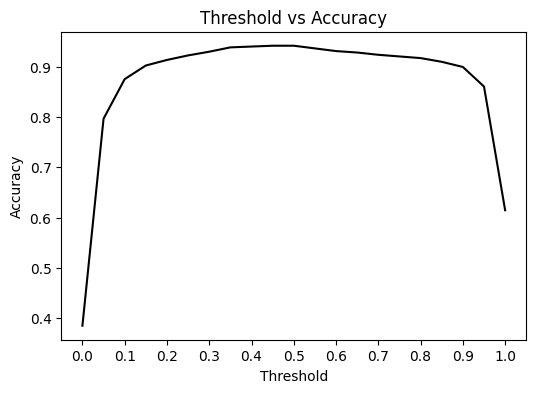

In [20]:
plt.figure(figsize=(6, 4))

plt.plot(thresholds, accuracies, color='black')

plt.title('Threshold vs Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')

plt.xticks(np.linspace(0, 1, 11))

# plt.savefig('04_threshold_accuracy.svg')

plt.show()

In [21]:
converted_small = y_pred_small >= 0.5
(converted_small == y_val).mean()

np.float64(0.7225409836065574)

In [22]:
accuracy_score(y_val, converted_small)

0.7225409836065574

In [23]:
size_val = len(y_val)
baseline = np.repeat(False, size_val)
baseline

array([False, False, False, ..., False, False, False])

In [24]:
accuracy_score(baseline, y_val)

0.6147540983606558

# Confusion Table

In [25]:
true_positive = ((y_pred >= 0.5) & (y_val == 1)).sum()
false_positive = ((y_pred >= 0.5) & (y_val == 0)).sum()
false_negative = ((y_pred < 0.5) & (y_val == 1)).sum()
true_negative = ((y_pred < 0.5) & (y_val == 0)).sum()

In [26]:
confusion_table = np.array(
     # predict neg    pos
    [[true_negative, false_positive], # actual neg
     [false_negative, true_positive]]) # actual pos

confusion_table

array([[1436,   64],
       [  78,  862]])

In [27]:
confusion_table / confusion_table.sum()

array([[0.58852459, 0.02622951],
       [0.03196721, 0.35327869]])

# Precision and recall

In [28]:
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
precision, recall

(np.float64(0.9308855291576674), np.float64(0.9170212765957447))

In [29]:

confusion_table / confusion_table.sum()

array([[0.58852459, 0.02622951],
       [0.03196721, 0.35327869]])

In [30]:
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
precision, recall


(np.float64(0.9308855291576674), np.float64(0.9170212765957447))

# ROC and AUC

TPR and FPR

In [31]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds: #B
    tp = ((y_pred >= t) & (y_val == 1)).sum()
    fp = ((y_pred >= t) & (y_val == 0)).sum()
    fn = ((y_pred < t) & (y_val == 1)).sum()
    tn = ((y_pred < t) & (y_val == 0)).sum()
    scores.append((t, tp, fp, fn, tn))

df_scores = pd.DataFrame(scores)
df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

In [32]:
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,940,1500,0,0
10,0.1,925,289,15,1211
20,0.2,906,177,34,1323
30,0.3,891,122,49,1378
40,0.4,882,88,58,1412
50,0.5,862,64,78,1436
60,0.6,824,52,116,1448
70,0.7,794,40,146,1460
80,0.8,767,29,173,1471
90,0.9,713,18,227,1482


In [33]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

In [34]:
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,940,1500,0,0,1.000000,1.000000
10,0.1,925,289,15,1211,0.984043,0.192667
20,0.2,906,177,34,1323,0.963830,0.118000
30,0.3,891,122,49,1378,0.947872,0.081333
40,0.4,882,88,58,1412,0.938298,0.058667
50,0.5,862,64,78,1436,0.917021,0.042667
60,0.6,824,52,116,1448,0.876596,0.034667
70,0.7,794,40,146,1460,0.844681,0.026667
80,0.8,767,29,173,1471,0.815957,0.019333
90,0.9,713,18,227,1482,0.758511,0.012000


Text(0.5, 1.0, 'TPR and FPR')

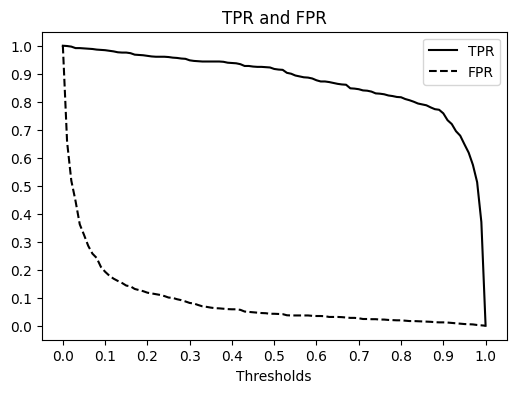

In [35]:

plt.figure(figsize=(6, 4))

plt.plot(df_scores.threshold, df_scores.tpr, color='black', linestyle='solid', label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, color='black', linestyle='dashed', label='FPR')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.xlabel('Thresholds')
plt.title('TPR and FPR')

# plt.savefig('04_fpr_tpr_plot.svg')

Random Basaline

In [36]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        tp = ((y_pred >= t) & (y_val == 1)).sum()
        fp = ((y_pred >= t) & (y_val == 0)).sum()
        fn = ((y_pred < t) & (y_val == 1)).sum()
        tn = ((y_pred < t) & (y_val == 0)).sum()

        scores.append((t, tp, fp, fn, tn))

    df_scores = pd.DataFrame(scores)
    df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores

In [37]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))
df_rand = tpr_fpr_dataframe(y_val, y_rand)
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,940,1500,0,0,1.000000,1.000000
10,0.1,849,1359,91,141,0.903191,0.906000
20,0.2,748,1212,192,288,0.795745,0.808000
30,0.3,665,1049,275,451,0.707447,0.699333
40,0.4,571,915,369,585,0.607447,0.610000
50,0.5,485,761,455,739,0.515957,0.507333
60,0.6,392,604,548,896,0.417021,0.402667
70,0.7,288,439,652,1061,0.306383,0.292667
80,0.8,192,311,748,1189,0.204255,0.207333
90,0.9,99,154,841,1346,0.105319,0.102667


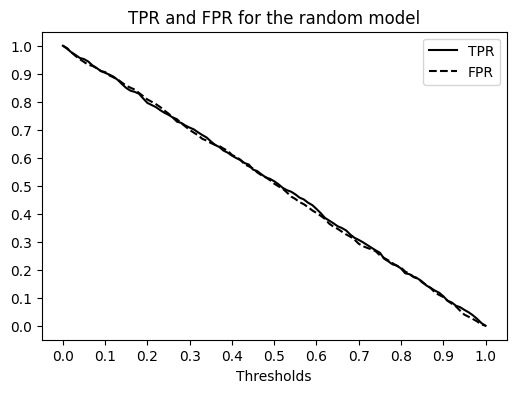

In [38]:
plt.figure(figsize=(6, 4))

plt.plot(df_rand.threshold, df_rand.tpr, color='black', linestyle='solid', label='TPR')
plt.plot(df_rand.threshold, df_rand.fpr, color='black', linestyle='dashed', label='FPR')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.xlabel('Thresholds')
plt.title('TPR and FPR for the random model')

#plt.savefig('04_fpr_tpr_plot_random.svg')

plt.show()

Ideal Baseline

In [39]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()

y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_pred_ideal = np.linspace(0, 1, num_neg + num_pos)

df_ideal = tpr_fpr_dataframe(y_ideal, y_pred_ideal)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,940,1500,0,0,1.000000,1.000000
10,0.1,940,1256,0,244,1.000000,0.837333
20,0.2,940,1012,0,488,1.000000,0.674667
30,0.3,940,768,0,732,1.000000,0.512000
40,0.4,940,524,0,976,1.000000,0.349333
50,0.5,940,280,0,1220,1.000000,0.186667
60,0.6,940,36,0,1464,1.000000,0.024000
70,0.7,732,0,208,1500,0.778723,0.000000
80,0.8,488,0,452,1500,0.519149,0.000000
90,0.9,244,0,696,1500,0.259574,0.000000


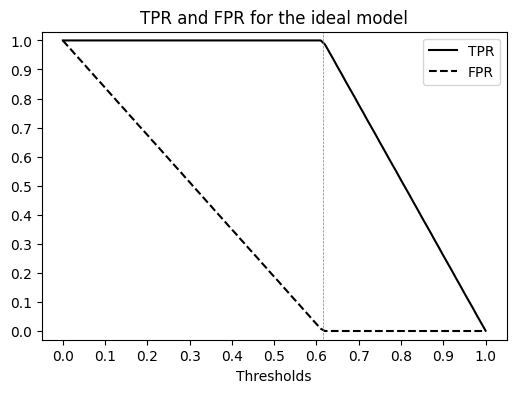

In [40]:
plt.figure(figsize=(6, 4))

plt.plot(df_ideal.threshold, df_ideal.tpr, color='black', linestyle='solid', label='TPR')
plt.plot(df_ideal.threshold, df_ideal.fpr, color='black', linestyle='dashed', label='FPR')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.vlines(1 - y_val.mean(), -1, 2, linewidth=0.5, linestyle='dashed', color='grey')
plt.ylim(-0.03, 1.03)

plt.xlabel('Thresholds')
plt.title('TPR and FPR for the ideal model')

# plt.savefig('04_fpr_tpr_plot_ideal.svg')

plt.show()

ROC Curve

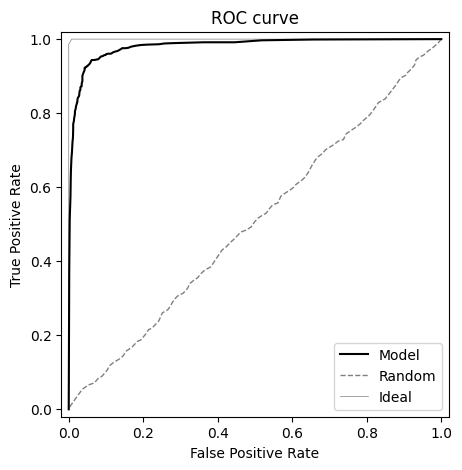

In [41]:

plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, color='black', label='Model')
plt.plot(df_rand.fpr, df_rand.tpr, color='black', lw=1,
         linestyle='dashed', alpha=0.5, label='Random')
plt.plot(df_ideal.fpr, df_ideal.tpr, color='black', lw=0.5,
         linestyle='solid', alpha=0.5, label='Ideal')

plt.legend()

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')

# plt.savefig('04_roc_curve_with_baselines.svg')

plt.show()

Using Scikit-Learn for plotting the ROC curve 

In [42]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [43]:

fpr, tpr, thresholds = roc_curve(y_val, y_pred)

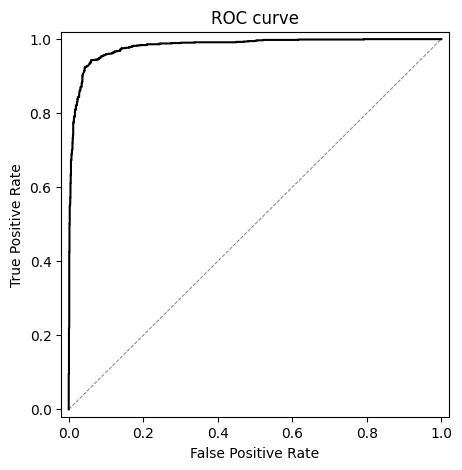

In [44]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, color='black')
plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')

plt.show()

AUC Area under the ROC curve

In [45]:

df_scores_small = tpr_fpr_dataframe(y_val, y_pred_small)

In [46]:
auc(df_scores.fpr, df_scores.tpr)

np.float64(0.9809531914893617)

In [47]:

auc(df_scores_small.fpr, df_scores_small.tpr)

np.float64(0.6660127659574469)

comparing multiple model with ROC curves

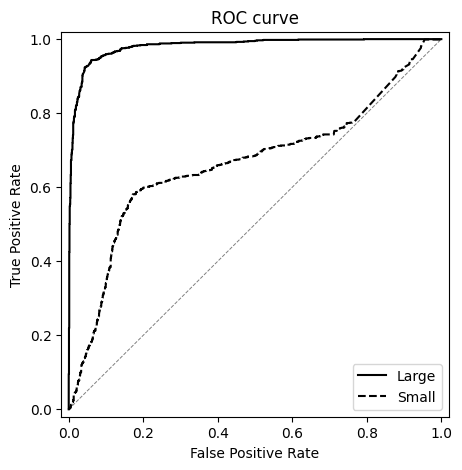

In [48]:
fpr_large, tpr_large, _ = roc_curve(y_val, y_pred)
fpr_small, tpr_small, _ = roc_curve(y_val, y_pred_small)

plt.figure(figsize=(5, 5))

plt.plot(fpr_large, tpr_large, color='black', linestyle='solid', label='Large')
plt.plot(fpr_small, tpr_small, color='black', linestyle='dashed', label='Small')
plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')
plt.legend(loc='lower right')

plt.show()

In [49]:
from sklearn.metrics import roc_auc_score

In [50]:

roc_auc_score(y_val, y_pred)

np.float64(0.9810609929078015)

In [51]:

roc_auc_score(y_val, y_pred_small)

np.float64(0.6647074468085106)

Interpretation of AUC: the probability that a randomly chosen positive example ranks higher than a randomly chosen negative example

In [52]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

np.random.seed(1)
neg_choice = np.random.randint(low=0, high=len(neg), size=10000)
pos_choice = np.random.randint(low=0, high=len(pos), size=10000)
(pos[pos_choice] > neg[neg_choice]).mean()

np.float64(0.9803)


# K-fold cross-validation

Manually doing the cross validation

In [53]:
def train(lead, y):
    cat = lead[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)
    
    
    X = dv.transform(cat)
    X = np.nan_to_num(X, nan=0)   

    model = LogisticRegression(solver='liblinear')
    model.fit(X, y)

    return dv, model


def predict(lead, dv, model):
    cat = lead[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(cat)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

Using Scikit Learn

In [54]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
import numpy as np


kfold = KFold(n_splits=10, shuffle=True, random_state=1)
aucs = []

for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx].copy()
    df_val = df_train_full.iloc[val_idx].copy()

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    # Drop target column before vectorizing
    df_train = df_train.drop(columns=['converted'])
    df_val = df_val.drop(columns=['converted'])

    # Convert to dictionary format
    train_dict = df_train.to_dict(orient='records')
    val_dict = df_val.to_dict(orient='records')

    # Vectorize
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dict)
    X_val = dv.transform(val_dict)

    # Fill missing values
    X_train = np.nan_to_num(X_train, nan=0)
    X_val = np.nan_to_num(X_val, nan=0)

    # Train logistic regression model
    model = LogisticRegression(solver='liblinear', random_state=1)
    model.fit(X_train, y_train)

    # Predict probabilities
    y_pred = model.predict_proba(X_val)[:, 1]

    # Calculate AUC
    rocauc = roc_auc_score(y_val, y_pred)
    aucs.append(rocauc)

    print(f"AUC: {rocauc:.3f}")

print(f"\nAverage AUC across folds: {np.mean(aucs):.3f}")


AUC: 0.677
AUC: 0.684
AUC: 0.655
AUC: 0.648
AUC: 0.627
AUC: 0.631
AUC: 0.662
AUC: 0.647
AUC: 0.673
AUC: 0.668

Average AUC across folds: 0.657


In [55]:

np.array(aucs).round(3)

array([0.677, 0.684, 0.655, 0.648, 0.627, 0.631, 0.662, 0.647, 0.673,
       0.668])

In [56]:
print('auc = %0.3f ± %0.3f' % (np.mean(aucs), np.std(aucs)))

auc = 0.657 ± 0.018


In [57]:
customer = {'lead_origin': 'lead_add_form',
 'lead_source': 'reference',
 'do_not_email': 'no',
 'do_not_call': 'no',
 'last_activity': 'sms_sent',
 'country': 'unk',
 'specialization': 'select',
 'how_did_you_hear_about_x_education': 'select',
 'what_is_your_current_occupation': 'unemployed',
 'what_matters_most_to_you_in_choosing_a_course': 'better_career_prospects',
 'search': 'no',
 'magazine': 'no',
 'newspaper_article': 'no',
 'x_education_forums': 'no',
 'newspaper': 'no',
 'digital_advertisement': 'no',
 'through_recommendations': 'no',
 'receive_more_updates_about_our_courses': 'no',
 'tags': 'will_revert_after_reading_the_email',
 'lead_quality': 'might_be',
 'update_me_on_supply_chain_content': 'no',
 'get_updates_on_dm_content': 'no',
 'lead_profile': 'select',
 'city': 'select',
 'asymmetrique_activity_index': 'unk',
 'asymmetrique_profile_index': 'unk',
 'i_agree_to_pay_the_amount_through_cheque': 'no',
 'a_free_copy_of_mastering_the_interview': 'no',
 'last_notable_activity': 'sms_sent',
 'totalvisits': 0.0,
 'total_time_spent_on_website': 0,
 'page_views_per_visit': 0.0,
 'asymmetrique_activity_score': 16.0,
 'asymmetrique_profile_score': 16.0}

In [58]:
def predict(lead, dv, model):
    cat = lead[categorical + numerical].to_dict(orient='records')
    X = dv.transform(cat)
    X = np.nan_to_num(X, nan=0)  
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred


import pandas as pd

df = pd.DataFrame([customer])
y_pred = predict(lead, dv, model)
y_pred[0]

np.float64(0.5000207295125941)

In [59]:

def predict_single(customer, dv, model):
    X = dv.transform([customer])
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred[0]

In [60]:

predict_single(customer, dv, model)

np.float64(0.5000264443301625)

In [61]:
import pickle 

with open('lead-model.bin', 'wb') as f_out:
    pickle.dump((dv, model), f_out)

In [64]:
import requests
url = 'http://localhost:9696/predict'
response = requests.post(url, json=customer)
result = response.json()
